<a href="https://colab.research.google.com/github/JaidyNar/TalentoTech/blob/master/Final_Bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRABAJO FINAL SOBRE BOOTCAMP ANALISIS DE DATOS NIVEL INNOVADOR**

**Estudiante**: Jaidy Viviana Narváez

Esta Base Datos Contiene información referente a los docentes de Cátedra de una universidad pública del año 2015 al año 2020.

# **Objetivo General**

Aplicar tecnicas de análisis de datos a información referente a los docentes de catedra contratados en una universidad pública desde el año 2015 hasta el año 2020


# **Objetivos Específicos**

*   Aplicar el mayor número posible de tecnicas aprendidas el el Bootcamp
*  Realizar un análisis descriptivo de los datos.
*   Examinar las correlaciones entre las puntuaciones obtenidas por los docentes y sus salarios para identificar posibles desequilibrios y errores en los pagos.
*  Ejecutar un modelo de regresión lineal múltiple para determinar los estimadores del modelo.











Importar paquetes necesarios

In [139]:
# Carga de paquetes necesarios
!pip install mysql-connector-python
!apt install libspatialindex-dev
!pip install rtree
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns
import numpy as np
import mysql.connector

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libspatialindex-dev is already the newest version (1.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Extracción de Los Datos**

El Dataset fué proporcionado por la división de talento humano de la universidad que contrató los docentes de catedra, se obtuvo por medio de un archivo adjunto, para efectos de este trabajo académico, previamente fuéron anonimizados los datos personales de los docentes y cargados a drive: https://docs.google.com/spreadsheets/d/1B51YoLPQEdjp32uWqIY7odhYhOy1FA4i/edit?usp=drive_link&ouid=103795500867631451829&rtpof=true&sd=true

In [141]:
# leer la base de datos
ruta = ("/content/drive/MyDrive/google colab/data_final.xlsx")
data_final = pd.read_excel(ruta)


# **Explorando el dataset**


In [142]:
# Realizo muestreo de los datos
data_final.sample(5)

,PERIODO,TIPO_IDEN,GENERO,FEC. INICIO,FEC. RETIRO,FACULTAD,DEPARTAMENTO,H. TRAB,VINCULACION,DEDICACION,CATEGORIA ESCALAFON,NIVEL DE EDUCACION,TITULO,PUNTOS,FEC. NACIMIENTO,EDAD,SALARIO
2101,2019-1,CC,MAS,2019-04-08,2019-07-26,FAC. ING. ELECTRONICA Y TEL.,DEPTO SISTEMAS,12.0,DOCENTE HORA CATEDRA,Horas,CATEGORIA A,PREGRADO,INGENIERO DE SISTEMAS,2.00,1987-12-21,33,1364160
2533,2020-1,CC,FEM,2020-02-03,2020-06-30,FAC. INGENIERIA CIVIL,DEPTO CONSTRUCCION,4.0,DOCENTE HORA CATEDRA,Horas,CATEGORIA A,PREGRADO,ARQUITECTA,2.00,1981-04-15,39,3273215
2152,2019-1,CC,FEM,2019-02-04,2019-03-14,FAC.ARTES,DEPTO MUSICA,6.0,DOCENTE HORA CATEDRA,Horas,CATEGORIA A,ESPECIALIZACIÓN CATEDRA,ESPECIALISTA EN GERENCIA DEL TALENTO HUMANO,2.50,1983-01-27,38,815880
528,2016-1,CC,MAS,2016-02-08,2016-06-03,FAC. CIENCIAS DE LA SALUD,DEPTO C. QUIRURGICAS,12.0,DOCENTE HORA CATEDRA,Horas,CATEGORIA D,ESPECIALIZACIÓN MEDICA CATEDRA,ACUERDO 043 - ESPECIALISTA EN CIRUGIA GENERAL,4.50,1952-08-03,68,2617920
826,2017-1,CC,MAS,2017-01-23,2017-12-20,"FAC. C. CONTABLES, ECON",DEPTO CIENCIAS ADMINISTRATIVAS,40.0,DOCENTE OCASIONAL,Tiempo completo,ASISTENTE,MAESTRIAS O MAGISTER,MAGISTER EN GESTION DE PROYECTOS,328.51,1971-05-21,49,3981541


In [143]:
# mirando los tipos de datos de las columnas
print(data_final.shape)
data_final.info()

(2929, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   PERIODO              2929 non-null   object        
 1   TIPO_IDEN            2929 non-null   object        
 2   GENERO               2929 non-null   object        
 3   FEC. INICIO          2929 non-null   datetime64[ns]
 4   FEC. RETIRO          2928 non-null   datetime64[ns]
 5   FACULTAD             2929 non-null   object        
 6   DEPARTAMENTO         2929 non-null   object        
 7   H. TRAB              2929 non-null   float64       
 8   VINCULACION          2929 non-null   object        
 9   DEDICACION           2929 non-null   object        
 10  CATEGORIA ESCALAFON  2916 non-null   object        
 11  NIVEL DE EDUCACION   2895 non-null   object        
 12  TITULO               2896 non-null   object        
 13  PUNTOS               2

In [144]:
# Buscando datos faltantes
data_final.isnull().sum()

PERIODO                 0
TIPO_IDEN               0
GENERO                  0
FEC. INICIO             0
FEC. RETIRO             1
FACULTAD                0
DEPARTAMENTO            0
H. TRAB                 0
VINCULACION             0
DEDICACION              0
CATEGORIA ESCALAFON    13
NIVEL DE EDUCACION     34
TITULO                 33
PUNTOS                  9
FEC. NACIMIENTO         0
EDAD                    0
SALARIO                 0
dtype: int64

En este punto se evidencian datos faltantes en las columna FEC. RETIRO, CATEGORIA ESCALAFON, NIVEL DE EDUCACION, TITULO y PUNTOS

In [145]:
# Describiendo las columnas numéricas
data_final.describe()


,FEC. INICIO,FEC. RETIRO,H. TRAB,PUNTOS,FEC. NACIMIENTO,EDAD,SALARIO
count,2929,2928,2929.000000,2920.000000,2929,2929.000000,2.929000e+03
mean,2017-09-28 15:47:52.379651584,2018-02-06 05:48:11.803278592,10.815807,34.337455,1974-12-18 15:53:46.357118464,45.766815,1.490292e+06
min,2014-08-11 00:00:00,2015-02-12 00:00:00,2.000000,0.000000,1941-08-20 00:00:00,24.000000,1.799360e+05
25%,2017-01-23 00:00:00,2017-05-18 12:00:00,5.000000,2.500000,1966-11-05 00:00:00,37.000000,8.702720e+05
50%,2017-08-01 00:00:00,2018-06-08 00:00:00,8.000000,3.000000,1977-04-02 00:00:00,43.000000,1.305408e+06
75%,2019-02-18 00:00:00,2019-03-14 00:00:00,12.000000,4.000000,1983-12-26 00:00:00,54.000000,1.958112e+06
max,2020-06-11 00:00:00,2020-12-11 00:00:00,40.000000,432.420000,1996-07-05 00:00:00,79.000000,5.240930e+06
std,NaN,NaN,9.711812,88.090682,NaN,11.323662,8.682316e+05


In [146]:
# Describiendo Las Columnas Categóricas
data_final.describe(include=['object'])

,PERIODO,TIPO_IDEN,GENERO,FACULTAD,DEPARTAMENTO,VINCULACION,DEDICACION,CATEGORIA ESCALAFON,NIVEL DE EDUCACION,TITULO
count,2929,2929,2929,2929,2929,2929,2929,2916,2895,2896
unique,6,2,2,9,52,2,3,11,10,782
top,2019-1,CC,MAS,FAC. CIENCIAS DE LA SALUD,DEPTO ENFERMERIA,DOCENTE HORA CATEDRA,Horas,CATEGORIA A,ESPECIALIZACIÓN CATEDRA,ENFERMERA
freq,736,2903,1787,655,219,2593,2593,1375,892,49


Al revisar la descripción de los objetos encontramos información en el dataset que no es de nuestro interés o que está de más, por ejemplo existen dos tipos de vinculación de los docentes pero sólo nos interesa los catedráticos, de igual manera hay 3 tipos de dedicación y de escalafón hay mas de los que corresponden a docentes de cátedra

# **Limpieza de Datos**

In [147]:
# cambiando nombres para facilitar la escritura del codigo

data_final.rename(columns={ 'PERIODO': 'periodo' ,'TIPO_IDEN': 'tipo_iden' , 'GENERO': 'genero' , 'FEC. INICIO': 'fecha_inicio' , 'FEC. RETIRO': 'fecha_retiro', 'FACULTAD': 'facultad' ,
                  'DEPARTAMENTO': 'departamento' , 'H. TRAB' : 'Horas_Trabajo'  , 'VINCULACION' : 'T_Vinculacion' , 'DEDICACION': 'dedicacion' , 'CATEGORIA ESCALAFON': 'categoria' ,
                  'NIVEL DE EDUCACION' : 'n_educacion' , 'TITULO' : 'titulo' , 'PUNTOS' : 'puntos' , 'FEC. NACIMIENTO' : 'fecha_nacimiento' , 'EDAD' : 'edad' , 'SALARIO' : 'salario' }, inplace=True)

In [148]:
# Verificar si se hicieron los cambios
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   periodo           2929 non-null   object        
 1   tipo_iden         2929 non-null   object        
 2   genero            2929 non-null   object        
 3   fecha_inicio      2929 non-null   datetime64[ns]
 4   fecha_retiro      2928 non-null   datetime64[ns]
 5   facultad          2929 non-null   object        
 6   departamento      2929 non-null   object        
 7   Horas_Trabajo     2929 non-null   float64       
 8   T_Vinculacion     2929 non-null   object        
 9   dedicacion        2929 non-null   object        
 10  categoria         2916 non-null   object        
 11  n_educacion       2895 non-null   object        
 12  titulo            2896 non-null   object        
 13  puntos            2920 non-null   float64       
 14  fecha_nacimiento  2929 n

In [149]:
# Eliminar los registros de los docentes que no son catedráticos
data_final = data_final[data_final['T_Vinculacion'] != 'DOCENTE OCASIONAL']

In [150]:
# Revisar cambios
data_final.describe(include=['object'])

,periodo,tipo_iden,genero,facultad,departamento,T_Vinculacion,dedicacion,categoria,n_educacion,titulo
count,2593,2593,2593,2593,2593,2593,2593,2580,2564,2565
unique,6,2,2,9,50,1,1,4,10,605
top,2019-1,CC,MAS,FAC. CIENCIAS DE LA SALUD,DEPTO ENFERMERIA,DOCENTE HORA CATEDRA,Horas,CATEGORIA A,ESPECIALIZACIÓN CATEDRA,ENFERMERA
freq,736,2574,1609,565,207,2593,2593,1375,892,45


Al revisar la variable n_educacion se evidencian muchos subniveles esucativos, organizaremos esos valores y eliminaremos la columna T_vinculación ya que ahora tenemos que todos son docentes de hora catedra

In [151]:
# Obtener los subniveles de la columna 'n_educacion'
subniveles = data_final['n_educacion'].unique()

print("Subniveles de 'n_educacion':")
print(subniveles)

Subniveles de 'n_educacion':
['PREGRADO' 'ESPECIALIZACIÓN CATEDRA' 'ESPECIALIZACIÓN MEDICA CATEDRA'
 'MAESTRIA CATEDRA' 'PREGRADO MEDICINA Y MUSICA' 'MAESTRIAS O MAGISTER'
 'DOCTORADO CATEDRA' 'ESPECIALIZACIONES' nan 'ESPECIALIZACIONES MEDICAS'
 'DOCTORADO']


In [152]:
# Renombrar subniveles
data_final['n_educacion'] = data_final['n_educacion'].replace({
    'ESPECIALIZACIÓN CATEDRA': 'ESPECIALIZACION', 'ESPECIALIZACIONES': 'ESPECIALIZACION', 'ESPECIALIZACIONES MEDICAS': 'MAESTRIA',
    'MAESTRIA CATEDRA': 'MAESTRIA', 'MAESTRIAS O MAGISTER': 'MAESTRIA',  'PREGRADO MEDICINA Y MUSICA': 'PREGRADO',
    'ESPECIALIZACIÓN MEDICA CATEDRA': 'ESPECIALIZACIONES MEDICAS', 'DOCTORADO CATEDRA': 'DOCTORADO'})

<ipython-input-152-b4c16f25aa8a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [153]:
# Revisar cambios
subniveles = data_final['n_educacion'].unique()
print("Subniveles de 'n_educacion':")
print(subniveles)

Subniveles de 'n_educacion':
['PREGRADO' 'ESPECIALIZACION' 'ESPECIALIZACIONES MEDICAS' 'MAESTRIA'
 'DOCTORADO' nan]


In [154]:
# Eliminar la columna Tipo de vinculacio 'T_vinculacion'
columnas_eliminar = ['T_Vinculacion']
data_final = data_final.drop(columnas_eliminar, axis="columns")

In [155]:
# Verificamos si se realizaron los cambio y buscamos nuevamente datos faltantes
data_final.isnull().sum()

periodo              0
tipo_iden            0
genero               0
fecha_inicio         0
fecha_retiro         1
facultad             0
departamento         0
Horas_Trabajo        0
dedicacion           0
categoria           13
n_educacion         29
titulo              28
puntos               9
fecha_nacimiento     0
edad                 0
salario              0
dtype: int64

In [156]:
# Creando un gráfico de datos faltantes para conocer cuantos valores incompletos hay en el conjunto de datos
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title = "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [157]:
print(data_final.shape)

(2593, 16)


In [158]:
# Plotting
missing_plot(data_final, 'periodo')

In [159]:
# Reemplazamos los valores faltantes por NaN
# Convertir valores None a NaN
data_final = data_final.replace({None: np.nan})
data_final[['fecha_retiro', 'categoria', 'n_educacion', 'titulo', 'puntos']] = data_final[['fecha_retiro', 'categoria', 'n_educacion', 'titulo', 'puntos']].replace(0,np.NaN)

# **Imputación de Datos Faltantes**
* Realizaremos Imputación KNN a la columna puntos que es la única columna numérica con datos faltantes



* para las demás columnas categórica utilizamos el método "drop rows" para eliminar las filas de datos faltantes esperando no causar una perdida significativa de información

 Aunque no existe un método definitivo para determinar el valor ideal de K, una heurística comúnmente utilizada sugiere que el K óptimo suele ser la raíz cuadrada del número total de muestras en el conjunto de datos. Normalmente, se elige un valor impar para K para evitar empates en la toma de decisiones. Para identificar la K más adecuada, comúnmente se utiliza un gráfico de error o un gráfico de precisión.

In [160]:
#Imputación KNN
# Crear el KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Aplicar el imputer a la columna 'puntos'
data_final['puntos'] = imputer.fit_transform(data_final[['puntos']])


In [161]:
# Eliminar filas con valores faltantes usando dropna
data_final.dropna(inplace=True)  # elimina fila completa con celdas vacías

In [162]:
#Verificamos si se realizaron los cambios
data_final.isnull().sum()


periodo             0
tipo_iden           0
genero              0
fecha_inicio        0
fecha_retiro        0
facultad            0
departamento        0
Horas_Trabajo       0
dedicacion          0
categoria           0
n_educacion         0
titulo              0
puntos              0
fecha_nacimiento    0
edad                0
salario             0
dtype: int64

In [163]:
print(data_final.shape)

(2557, 16)


# **Estadisticas Descriptivas**


1.   Busquemos valores atipicos en las variables
2.   Contemos el número de docentes según genero en cada año
3.   Número de docentes por genero en cada facultad
4.   Nivel Edúcativo de los docentes a través de los años
5.   Análisis de correlaciones




In [164]:
# Describiendo las columnas numéricas
data_final.describe()

,fecha_inicio,fecha_retiro,Horas_Trabajo,puntos,fecha_nacimiento,edad,salario
count,2557,2557,2557.000000,2557.000000,2557,2557.000000,2.557000e+03
mean,2017-11-01 19:01:31.513492224,2018-02-14 19:39:49.206100992,7.638052,3.092100,1974-06-17 10:23:25.084082912,46.272976,1.306481e+06
min,2014-08-11 00:00:00,2015-02-12 00:00:00,2.000000,2.000000,1941-08-20 00:00:00,24.000000,1.799360e+05
25%,2016-02-08 00:00:00,2016-06-03 00:00:00,4.000000,2.500000,1966-02-14 00:00:00,37.000000,8.066520e+05
50%,2018-02-05 00:00:00,2018-06-08 00:00:00,8.000000,3.000000,1976-08-06 00:00:00,44.000000,1.163520e+06
75%,2019-04-08 00:00:00,2019-07-26 00:00:00,10.000000,4.000000,1983-10-25 00:00:00,55.000000,1.740544e+06
max,2020-06-11 00:00:00,2020-12-11 00:00:00,12.000000,5.000000,1996-07-05 00:00:00,79.000000,4.645718e+06
std,NaN,NaN,3.017442,0.838846,NaN,11.570791,6.595367e+05


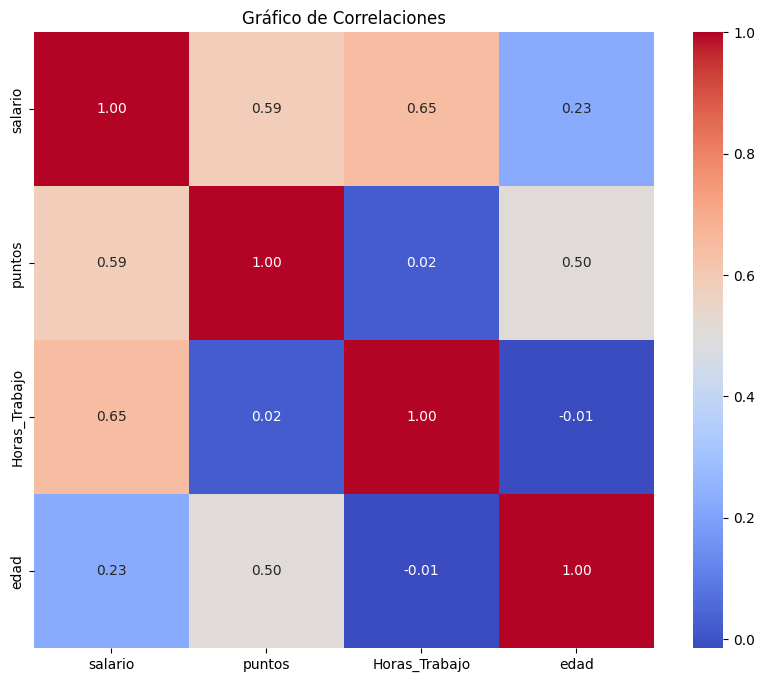

In [165]:
# Seleccionar las columnas de interés para el análisis de correlaciones
cols = ['salario', 'puntos', 'Horas_Trabajo', 'edad']
data_final_selected = data_final[cols]

# Calcular la matriz de correlaciones
correlation_matrix = data_final_selected.corr()

# Crear el gráfico de correlaciones utilizando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Gráfico de Correlaciones')

# Mostrar el gráfico
plt.show()

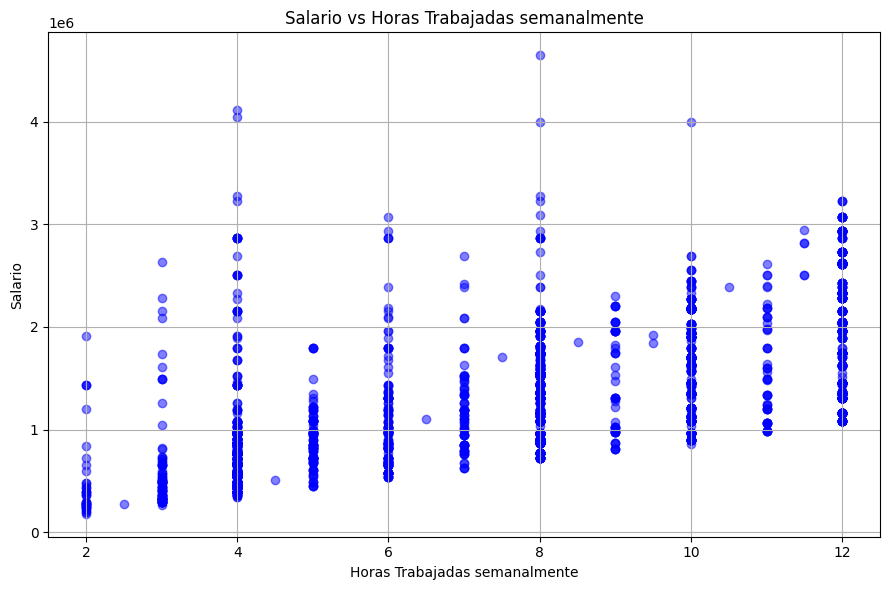

In [166]:
# Crear el gráfico de dispersión
plt.figure(figsize=(9, 6))
plt.scatter(data_final['Horas_Trabajo'], data_final['salario'], color='blue', alpha=0.5)  # Usamos alpha para transparencia

# Añadir etiquetas y título
plt.xlabel('Horas Trabajadas semanalmente')
plt.ylabel('Salario')
plt.title('Salario vs Horas Trabajadas semanalmente')

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

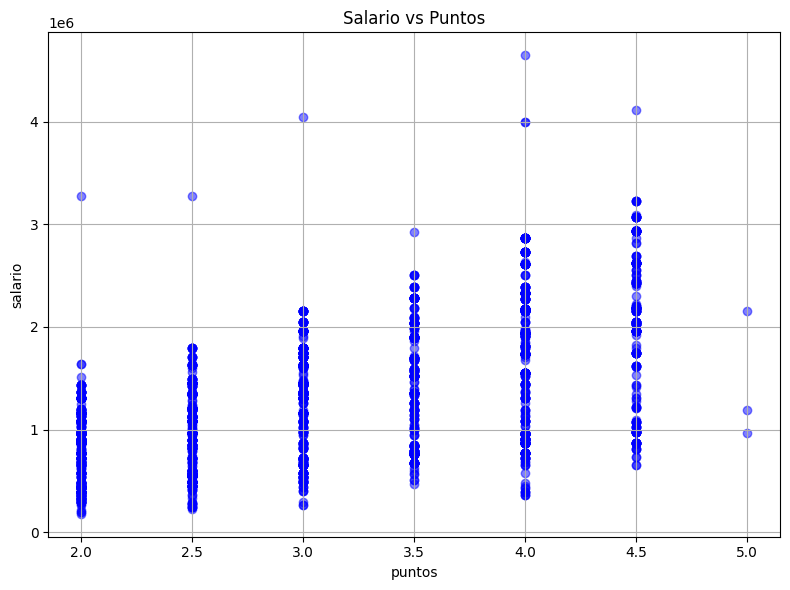

In [167]:
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(data_final['puntos'], data_final['salario'], color='blue', alpha=0.5)  # Usamos alpha para transparencia

# Añadir etiquetas y título
plt.xlabel('puntos')
plt.ylabel('salario')
plt.title('Salario vs Puntos')

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

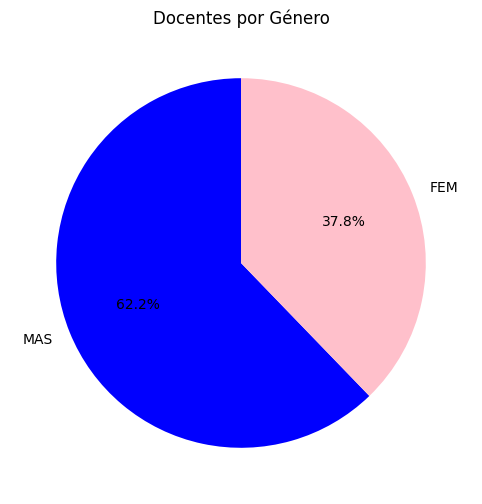

In [168]:
# Obtener porcentaje  de docentes por género
docentes_por_genero = data_final['genero'].value_counts()

# Crear el gráfico circular
docentes_por_genero.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'pink'], startangle=90)
plt.title('Docentes por Género')
plt.ylabel('')  # Eliminar la etiqueta del eje y, que no se usa en gráficos circulares
plt.show()



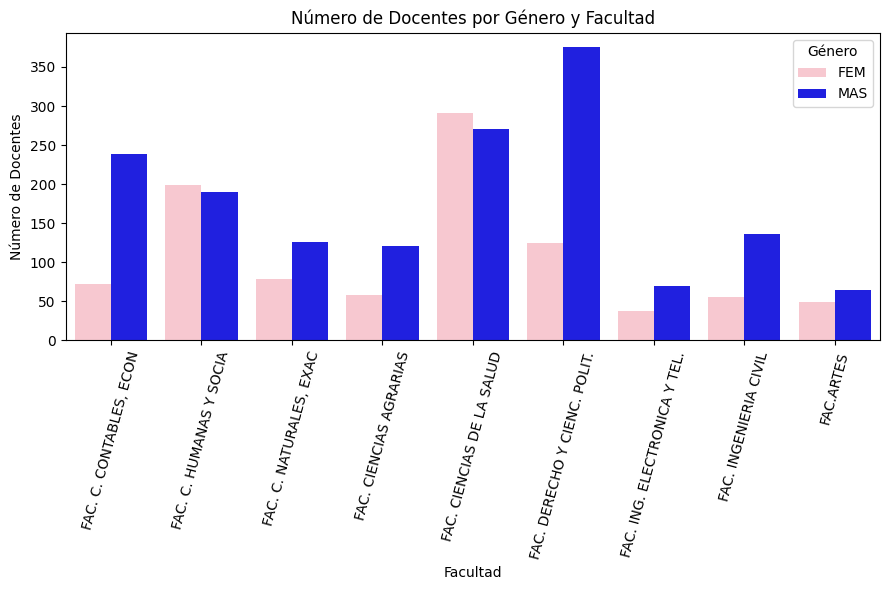

In [169]:

# Contar el número de docentes por género y facultad
conteo_por_genero_y_facultad = data_final.groupby(['facultad', 'genero']).size().reset_index(name='numero_de_docentes')

# Definir una paleta de colores personalizada
colores_personalizados = ['pink' , 'blue']

# Crear el gráfico de barras
plt.figure(figsize=(9, 6))

# Usamos seaborn para facilitar la creación de gráficos complejos
bar_plot = sns.barplot(data=conteo_por_genero_y_facultad, x='facultad', y='numero_de_docentes', hue='genero', palette=colores_personalizados)

# Añadir etiquetas y título
plt.xlabel('Facultad')
plt.ylabel('Número de Docentes')
plt.title('Número de Docentes por Género y Facultad')
plt.xticks(rotation=75)  # Rotar etiquetas del eje x para mejor legibilidad
# Mostrar el gráfico
plt.legend(title='Género')
plt.tight_layout()  # Ajustar el layout para que no se corten las etiquetas
plt.show()


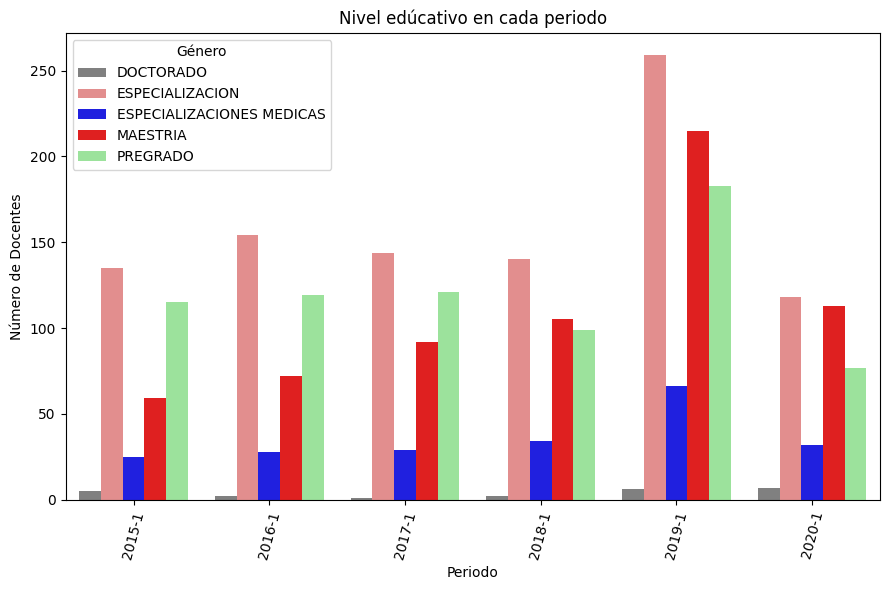

In [196]:
# Contar el número de docentes por género y facultad
conteo_por_periodo_y_facultad = data_final.groupby(['periodo', 'n_educacion']).size().reset_index(name='numero_de_docentes')

# Ordenar el DataFrame por la columna 'numero_de_docentes' en orden ascendente
conteo_nivel_educativo_por_año_sorted = conteo_por_periodo_y_facultad.sort_values(by='periodo', ascending=True)

# Definir una paleta de colores personalizada
colores_personalizados = ['grey', '#F08080', 'blue', 'red', '#90EE90']

# Crear el gráfico de barras ordenado
plt.figure(figsize=(9, 6))
bar_plot = sns.barplot(data=conteo_nivel_educativo_por_año_sorted, x='periodo', y='numero_de_docentes', hue='n_educacion', palette=colores_personalizados)

# Añadir etiquetas y título
plt.xlabel('Periodo')
plt.ylabel('Número de Docentes')
plt.title('Nivel edúcativo en cada periodo')
plt.xticks(rotation=75)  # Rotar etiquetas del eje x para mejor legibilidad
plt.legend(title='Género')
plt.tight_layout()  # Ajustar el layout para que no se corten las etiquetas
plt.show()



# **Creando un módelo de Regresión**

In [171]:

# Seleccionar las columnas predictoras y la columna objetivo
X = data_final[['Horas_Trabajo', 'puntos']]  # Variables predictoras
y = data_final['salario']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Los datos se dividen en conjuntos de entrenamiento (80%) y prueba (20%) para evaluar el modelo.

# Crear el modelo de regresión lineal
modelo = LinearRegression()

# Entrenar el modelo
modelo.fit(X_train, y_train)

# Predecir con el conjunto de prueba
y_pred = modelo.predict(X_test)

# Mostrar los coeficientes del modelo
print("Intercepto:", modelo.intercept_)
print("Coeficientes:", modelo.coef_)




Intercepto: -1115138.9816198032
Coeficientes: [137248.23838565 444468.48338497]


**Evaluemos el modelo**

In [172]:
# evaluando el comportamiento del modelo te dice qué tan lejos están, en promedio, las predicciones de los valores reales (mide la magnitud del error).
print("Mean Squared Error:",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(y_test, y_pred)))

# en promedio, las predicciones del modelo difieren del valor real del salario por aproximadamente 319125 pesos

Mean Squared Error: 101840867065.17711
Root Mean Squared Error: 319125.1589348247


In [173]:
r2 = r2_score(y_test, y_pred)
print("R^2:",r2_score(y_test, y_pred))

# 78% de la variabilidad en los salarios se puede explicar por las horas de trabajo y los puntos de rendimiento.

R^2: 0.7811901130386074


In [174]:
# Crear un DataFrame con los valores reales y predichos
predictedsalario = pd.DataFrame(y_pred, columns=['Predicted salario'])
actualsalario = pd.DataFrame(y_test).reset_index(drop=True)
data_actual_vs_predicted = pd.concat([actualsalario, predictedsalario], axis=1)
data_actual_vs_predicted.T




,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
salario,815880.000000,1.332604e+06,9.560320e+05,1.163520e+06,1.364160e+06,727200.000000,761488.00000,2.175680e+06,761488.00000,2.937168e+06,...,1.087840e+06,2.046240e+06,652704.000000,543920.000000,9.790560e+05,1.631760e+06,1.087840e+06,2.181600e+06,1.136800e+06,9.790560e+05
Predicted salario,819521.657157,1.401238e+06,1.211728e+06,1.420777e+06,1.420777e+06,819521.657157,989493.66377,2.035217e+06,989493.66377,2.531948e+06,...,1.094018e+06,1.865245e+06,597287.415464,545025.180385,1.433962e+06,1.643011e+06,1.094018e+06,2.257452e+06,1.146280e+06,1.009032e+06


En la tabla se aprecia que aunque tenemos un gran número de datos cercanos hay unos pocos dispersos, además que no tenemos datos negativos ni ceros. Sin embargo, grafiquemos para evaluar el modelo

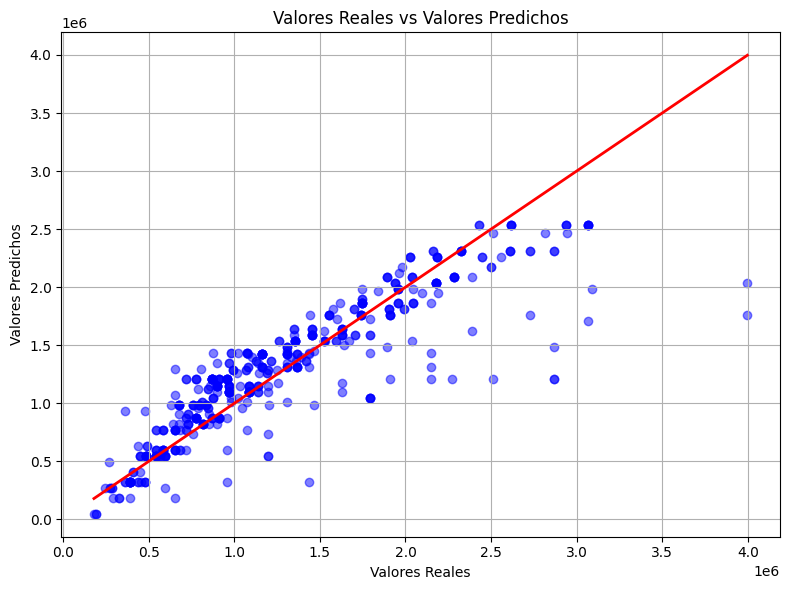

In [175]:
#Se crea un gráfico de dispersión de los valores reales vs. los valores predichos para visualizar el rendimiento del modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Valores Predichos')
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Histograma de las diferencias')

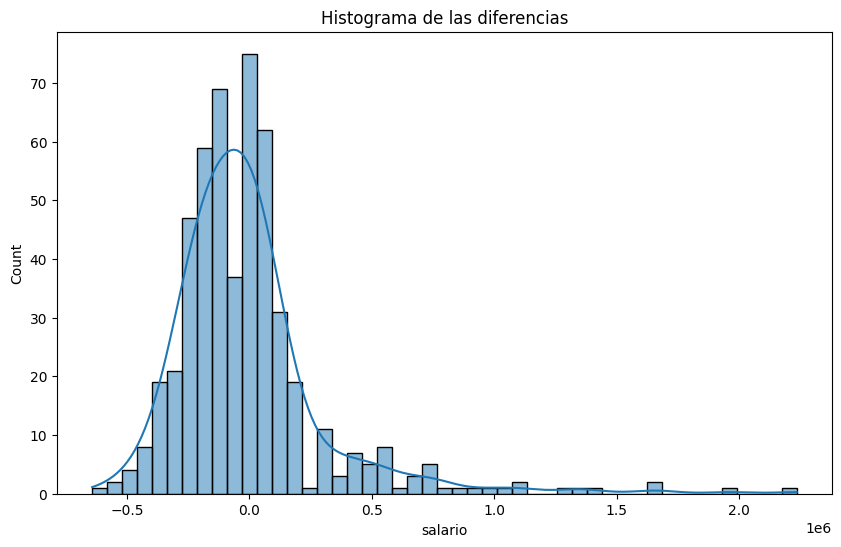

In [176]:
# Evaluando el modelo con un histograma que grafique la diferencia entre y_test y las predicciones del modelo
sns.histplot(y_test-y_pred, kde=True)
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Histograma de las diferencias")


# **Crear una lista y una conexión a una Base de Datos SQLite con las Predicciones de los Salarios de acuerdo a los puntos y a las horas que trabaja semanalmente**


In [177]:
# Creamos un dataset de las predicciones de los salarios respecto a las horas de  trabajo semanalmente y los puntos asignados a un docente
modelo_regresion = LinearRegression()

# Crear un DataFrame con los datos de test
datos_test = {
    'Horas_Trabajo': [1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12,
                      1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11, 12],
    'puntos': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
               2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
               3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
               4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
               5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
               6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
               0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
               1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
               2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
               3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
               4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5,
               5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5],

  }

df_test = pd.DataFrame(datos_test)

# Entrenar el modelo de regresión si aún no lo has hecho
modelo_regresion.fit(X_train, y_train)  # Ajusta el modelo con tus datos de entrenamiento

# Hacer predicciones con el modelo de regresión
df_test['Predicted salario'] = modelo_regresion.predict(df_test[['Horas_Trabajo', 'puntos']])

# Mostrar el DataFrame con las predicciones de salario
print(df_test)


     Horas_Trabajo  puntos  Predicted salario
0                1     1.0      -5.334223e+05
1                2     1.0      -3.961740e+05
2                3     1.0      -2.589258e+05
3                4     1.0      -1.216775e+05
4                5     1.0       1.557069e+04
..             ...     ...                ...
139              8     5.5       2.427424e+06
140              9     5.5       2.564672e+06
141             10     5.5       2.701920e+06
142             11     5.5       2.839168e+06
143             12     5.5       2.976417e+06

[144 rows x 3 columns]


In [192]:
# Guardar el DataFrame en un archivo CSV
df_test.to_csv('predicciones_salario.csv', index=False)

In [178]:
# Guardar el DataFrame en un archivo CSV

df_test.to_csv('predicciones_salario.csv', index=False)

# **Conclusiones**


* El docente más joven contratado por la universidad como catedrático entre los año 2015 y 2020 tenia 46 años, respectivamente el de mayor edad tenia 79 años
*  El salario de los docentes está directamente correlacionado con los puntos debido a la experiencia y estudios, tambien está directamente relacionando con las horas que labora semanalmente
*   En la Universidad se han contratado mas hombres que mujeres como docentes de cátedra
*   Analizando por facultades la mayor desigualdad de género en la contratación de docentes de cátedra se evidencia en la facultad de derecho, donde la contratación de hombres ha sido de un 69 por ciento en hombres y un 31 por ciento en mujeres.

*   Desde primer semestre del año 2015 al primer semestre del año 2017 primaban docentes con nivel educativo de especialización, a partir de allí hasta el año 2020 en mayor porcentaje tenian maestría.
*   El modelo de regresión lineal multiple que predice el salario de los docentes con respecto a los puntos y horas de trabajo que labora semanalmente muestra que el 78% de la variabilidad en los salarios se puede explicar por las horas de trabajo y los puntos de rendimiento.

*   Al Crear un DataFrame con los valores reales y predichos
*   Elemento de lista se aprecia que aunque tenemos un gran número de datos cercanos hay unos otro valores dispersos.










# **Referencias:**
El código utilizado en este análisis proviene de diversos proyectos del bootcamp "Análisis de Datos Nivel Innovador", donde se aprendieron y aplicaron prácticas avanzadas en el manejo, visualización, imputación de datos y metodos de regresión lineal.

Además, se ha contado con el soporte y la colaboración de ChatGPT, que ha proporcionado ayuda en algunos códigos para crear gráficos de barras, de dispersión y para crear una lista que genere un dataset que se pueda guardar en un formatos csv y crear una conexión a una Base de Datos SQLite